# Project ---> Census Income

### Project Description

*This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.*

### Description of fnlwgt (final weight) 

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are: 

1. A single cell estimate of the population 16+ for each state. 
2.Controls for Hispanic Origin by age and sex. 
3. Controls by Race, age and sex. 

`We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.` 



## Import dependencies


In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy import stats
import scipy.stats as stats
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve,auc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")
data.sample(5)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
28188,38,Private,114059,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,<=50K
649,20,Private,130959,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,20,United-States,<=50K
12228,23,Private,196674,Some-college,10,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
30062,28,Private,584790,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,>50K
29462,34,Private,242984,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [3]:
data.shape

(32560, 15)

In [4]:
# Replace income value more than 50k with 1 and less than 50k with 0.
data['Income'] =data['Income'].str.strip()
data['Income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)


In [5]:
# droping duplicates
data.drop_duplicates(keep='first', inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32536 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32536 non-null  int64 
 1   Workclass       32536 non-null  object
 2   Fnlwgt          32536 non-null  int64 
 3   Education       32536 non-null  object
 4   Education_num   32536 non-null  int64 
 5   Marital_status  32536 non-null  object
 6   Occupation      32536 non-null  object
 7   Relationship    32536 non-null  object
 8   Race            32536 non-null  object
 9   Sex             32536 non-null  object
 10  Capital_gain    32536 non-null  int64 
 11  Capital_loss    32536 non-null  int64 
 12  Hours_per_week  32536 non-null  int64 
 13  Native_country  32536 non-null  object
 14  Income          32536 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 4.0+ MB


In [7]:
data.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [8]:
def unique_val(data):
    for column in data.columns:
        print(f"Column Name: {column}")
        if len(data[column].unique()) > 16:
            print(data[column].nunique())
            print("______________________________________________________________________________________________")
        else:
            print(data[column].unique())
            print("______________________________________________________________________________________________")


# Call the function to print unique values for each column
unique_val(data)


Column Name: Age
73
______________________________________________________________________________________________
Column Name: Workclass
[' Self-emp-not-inc' ' Private' ' State-gov' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
______________________________________________________________________________________________
Column Name: Fnlwgt
21647
______________________________________________________________________________________________
Column Name: Education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
______________________________________________________________________________________________
Column Name: Education_num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
______________________________________________________________________________________________
Column Name: Marital_status
[' Married-civ

In [9]:
def find_features_with_missing_values(data):
    # Replace characters with NaN
    replace_chars = ["\n", "\n?\n", "?","\n?"," ?","? "," ? "," ?\n"]
    if any(char in data.values for char in replace_chars):
        data.replace(replace_chars, np.nan, inplace=True)
        print("Successfully replaced characters with NaN.")
    
    # Find features with missing values
    features_with_null = [feature for feature in data.columns if data[feature].isnull().sum() > 0]
    if not features_with_null:
        print("No missing values found in any features.")
    else:
        for feature in features_with_null:
            print(f"{feature}: {round(data[feature].isnull().mean() * 100, 2)}%")
    return features_with_null



In [10]:
find_features_with_missing_values(data)

Successfully replaced characters with NaN.
Workclass: 5.64%
Occupation: 5.66%
Native_country: 1.79%


['Workclass', 'Occupation', 'Native_country']

# Handling missing values

In [11]:
# Imputating Missing value with mode for categorical features
data['Occupation'].fillna(data['Occupation'].mode()[0],inplace=True)
data['Workclass'].fillna(data['Workclass'].mode()[0],inplace=True)
data['Native_country'].fillna(data['Native_country'].mode()[0],inplace=True)

In [12]:
find_features_with_missing_values(data)

No missing values found in any features.


[]

In [13]:
# Clean up occupation column by removing any leading/trailing spaces
data['Occupation'] = data['Occupation'].str.strip()
# Replace occupation categories with new categories
data['new_occupation'] = data['Occupation'].replace({
    'Prof-specialty': 'Professional_Managerial',
    'Craft-repair': 'Skilled_Technical',
    'Exec-managerial': 'Professional_Managerial',
    'Adm-clerical': 'Sales_Administrative',
    'Sales': 'Sales_Administrative',
    'Other-service': 'Service_Care',
    'Machine-op-inspct': 'Skilled_Technical',
    'Missing': 'Unclassified Occupations',
    'Transport-moving': 'Skilled_Technical',
    'Handlers-cleaners': 'Service_Care',
    'Farming-fishing': 'Service_Care',
    'Tech-support': 'Skilled_Technical',
    'Protective-serv': 'Professional_Managerial',
    'Priv-house-serv': 'Service_Care',
    'Armed-Forces': 'Unclassified Occupations',
})

# Check value counts of new occupation column
data.drop(['Occupation'], axis=1,inplace=True)
print(f"New narrowed categories : \n{data['new_occupation'].value_counts()}")

New narrowed categories : 
Professional_Managerial     10693
Skilled_Technical            8618
Sales_Administrative         7417
Service_Care                 5799
Unclassified Occupations        9
Name: new_occupation, dtype: int64


In [14]:
# dropping education because we have education_num
data.drop("Education",axis=1,inplace=True)

In [15]:
data.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education_num     0
Marital_status    0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
new_occupation    0
dtype: int64

In [16]:
data.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Income
count,32536.000000,3.253600e+04,32536.000000,32536.000000,32536.000000,32536.000000,32536.000000
mean,38.585536,1.897843e+05,10.081725,1078.410069,87.370912,40.440343,0.240933
std,13.638193,1.055563e+05,2.571622,7388.068465,403.107737,12.347079,0.427656
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369932e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


Here's a summary for the provided dataset with the given features:

- **Age:**
  - Ranges from 17 to 90 years.
  - Average age is approximately 38.59 years.
  - Represents the age of individuals.

- **Fnlwgt:**
  - Ranges from 12,285 to 1,484,705.
  - Average final weight is around 189,784.3.
  - This feature might represent a weight that's used in statistical sampling.

- **Education_num:**
  - Ranges from 1 to 16.
  - Average education number is approximately 10.08.
  - Likely corresponds to the number of years of education completed.

- **Capital_gain:**
  - Ranges from 0 to 99,999.
  - Average capital gain is about 1,078.41.
  - Reflects capital gains, such as profits from the sale of assets.

- **Capital_loss:**
  - Ranges from 0 to 4,356.
  - Average capital loss is around 87.37.
  - Reflects capital losses, such as losses from the sale of assets.

- **Hours_per_week:**
  - Ranges from 1 to 99 hours per week.
  - Average hours worked per week is approximately 40.44.
  - Represents the number of hours worked on average.

- **Income:**
  - Takes values 0 or 1 (binary classification).
  - Average income is approximately 0.24, suggesting imbalanced classes.
  - Likely indicates whether an individual's income is above a certain threshold.


In [17]:
# splitting into numeric and categorical columns
num_col = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
cat_col = [col for col in data.columns if data[col].dtype == 'object']


In [18]:
print(f" Numeric Columns:{len(num_col) }\n", num_col)
print(f" Categorical Columns:{len(cat_col)}\n", cat_col)


 Numeric Columns:7
 ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Income']
 Categorical Columns:7
 ['Workclass', 'Marital_status', 'Relationship', 'Race', 'Sex', 'Native_country', 'new_occupation']


In [19]:
# checking the value counts
data.Education_num.value_counts()

9     10494
10     7282
13     5352
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: Education_num, dtype: int64

In [20]:
data.Workclass.value_counts()

 Private             24509
 Self-emp-not-inc     2540
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

# Univariate analysis

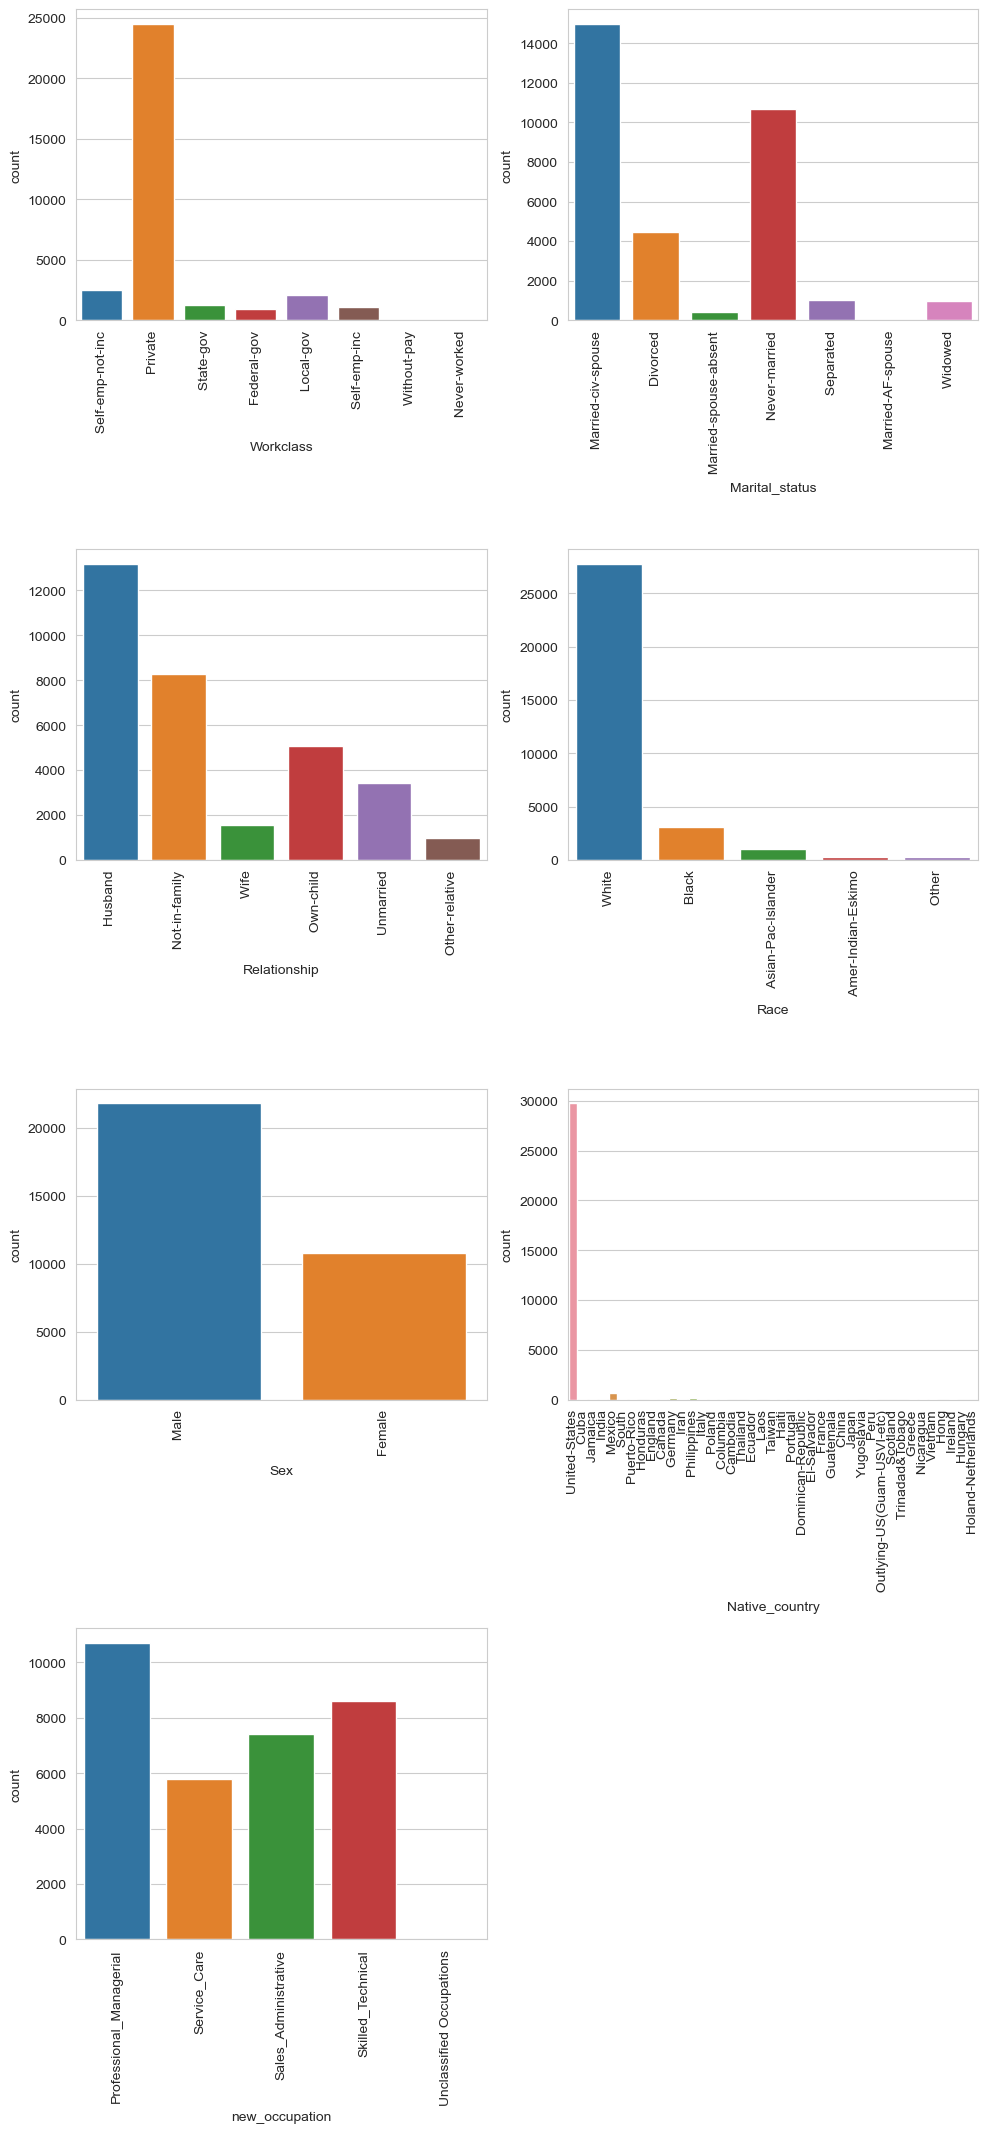

In [21]:
# Create the subplots
fig = plt.figure(figsize=(10, 25))

# Loop through categorical columns and plot count plots
for i, col in enumerate(cat_col):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=data, x=col)
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


* In work class private have counts 
* In race class white have the majority
* In native_country united states have the majority
* In sex class male are more in numbers 
* In material_stauts marriedcivspouse and never married are more in numbers
* other columns are distributed pretty properly


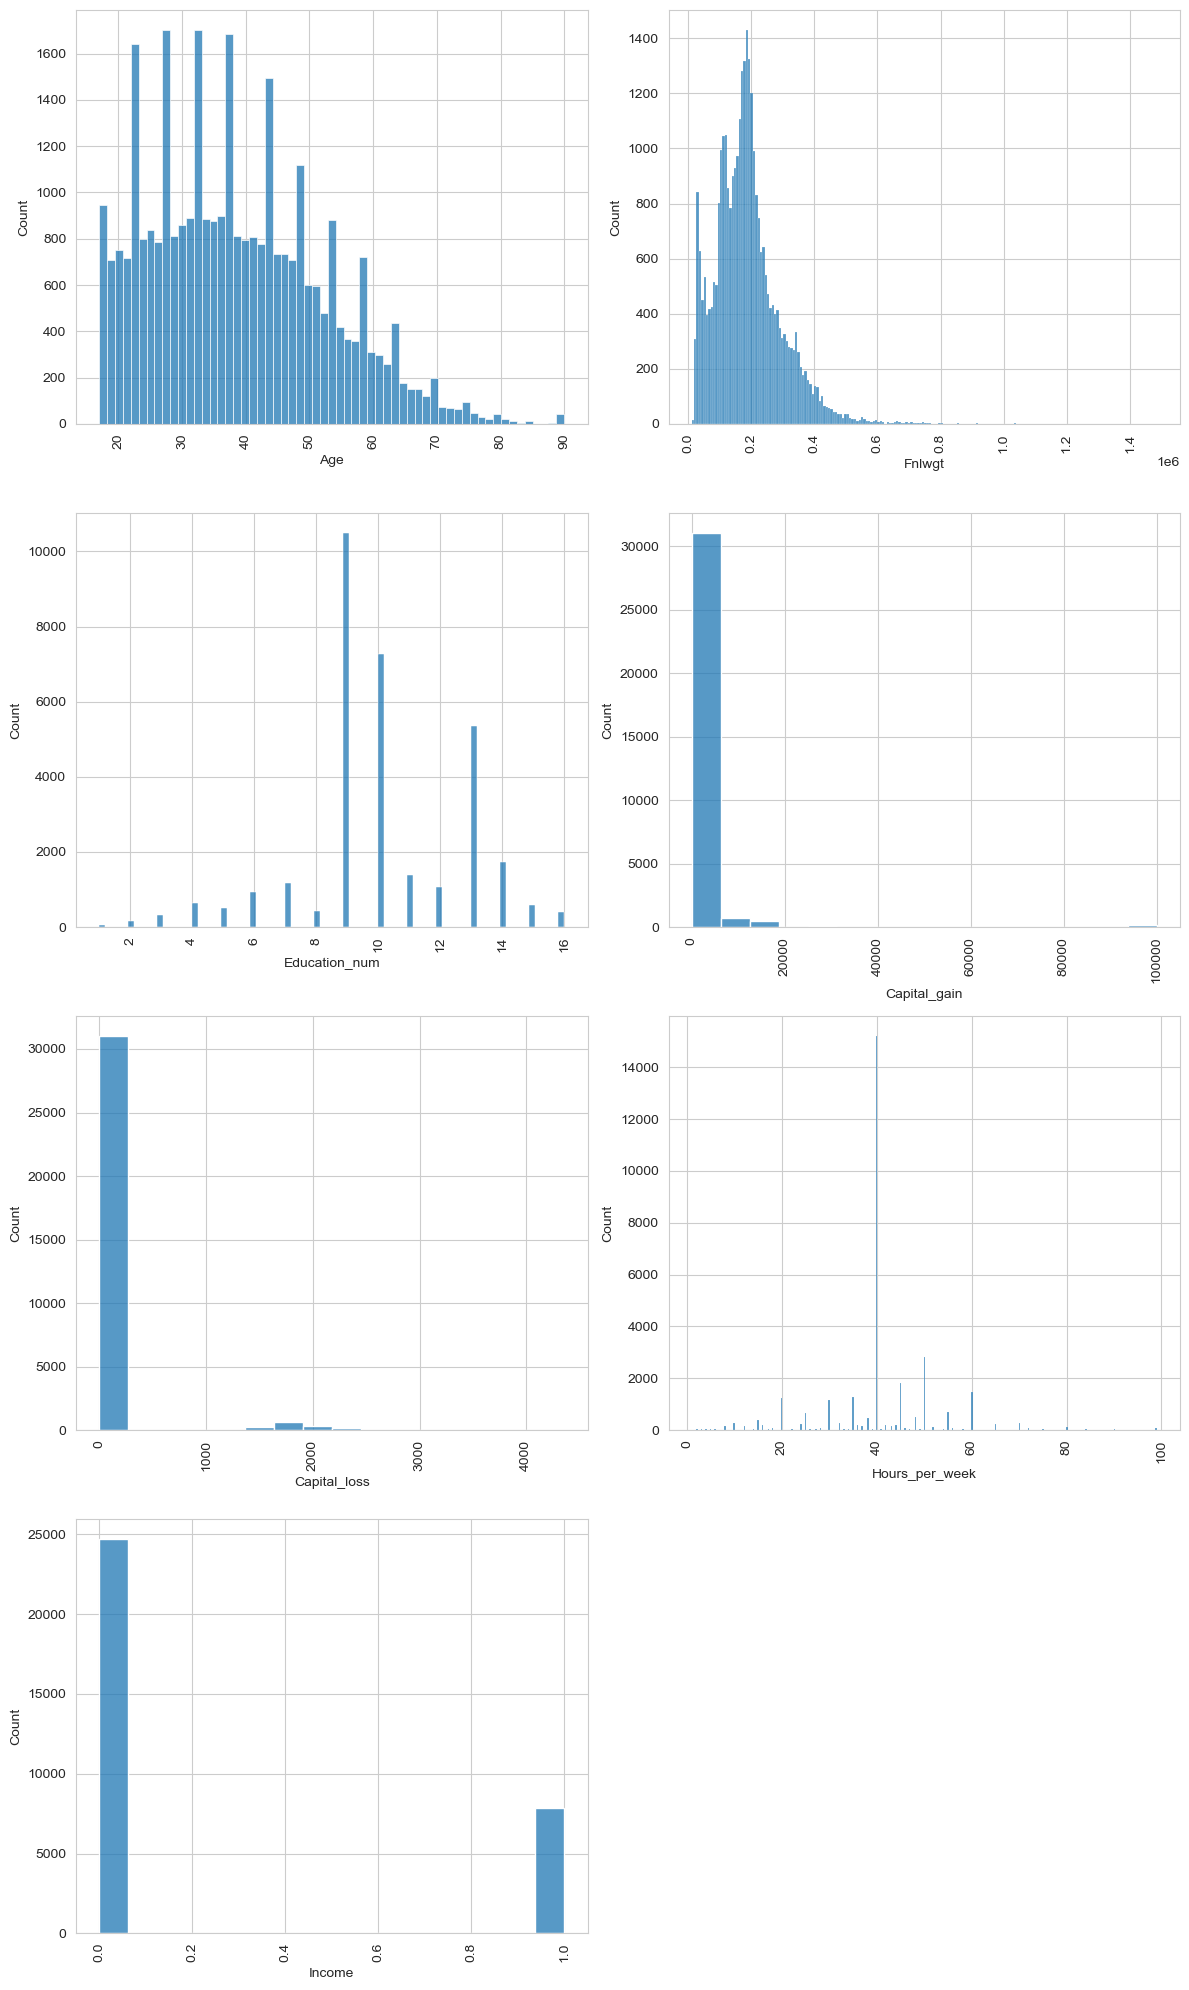

In [22]:
# Create the subplots
fig = plt.figure(figsize=(12, 20))


# Loop through categorical columns and plot count plots
for i, col in enumerate(num_col):
    plt.subplot(4, 2, i + 1)
    sns.histplot(data=data, x=col)
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()





* age more between 20 to 60
* fnlwgt range high between 0.1,0.6
* education number are highest between nine and ten
* capital gain highest in the range of 0 to 20000
* capital loss highest in the range of 0 to 2000
* hours_per_week average is around 40 hours

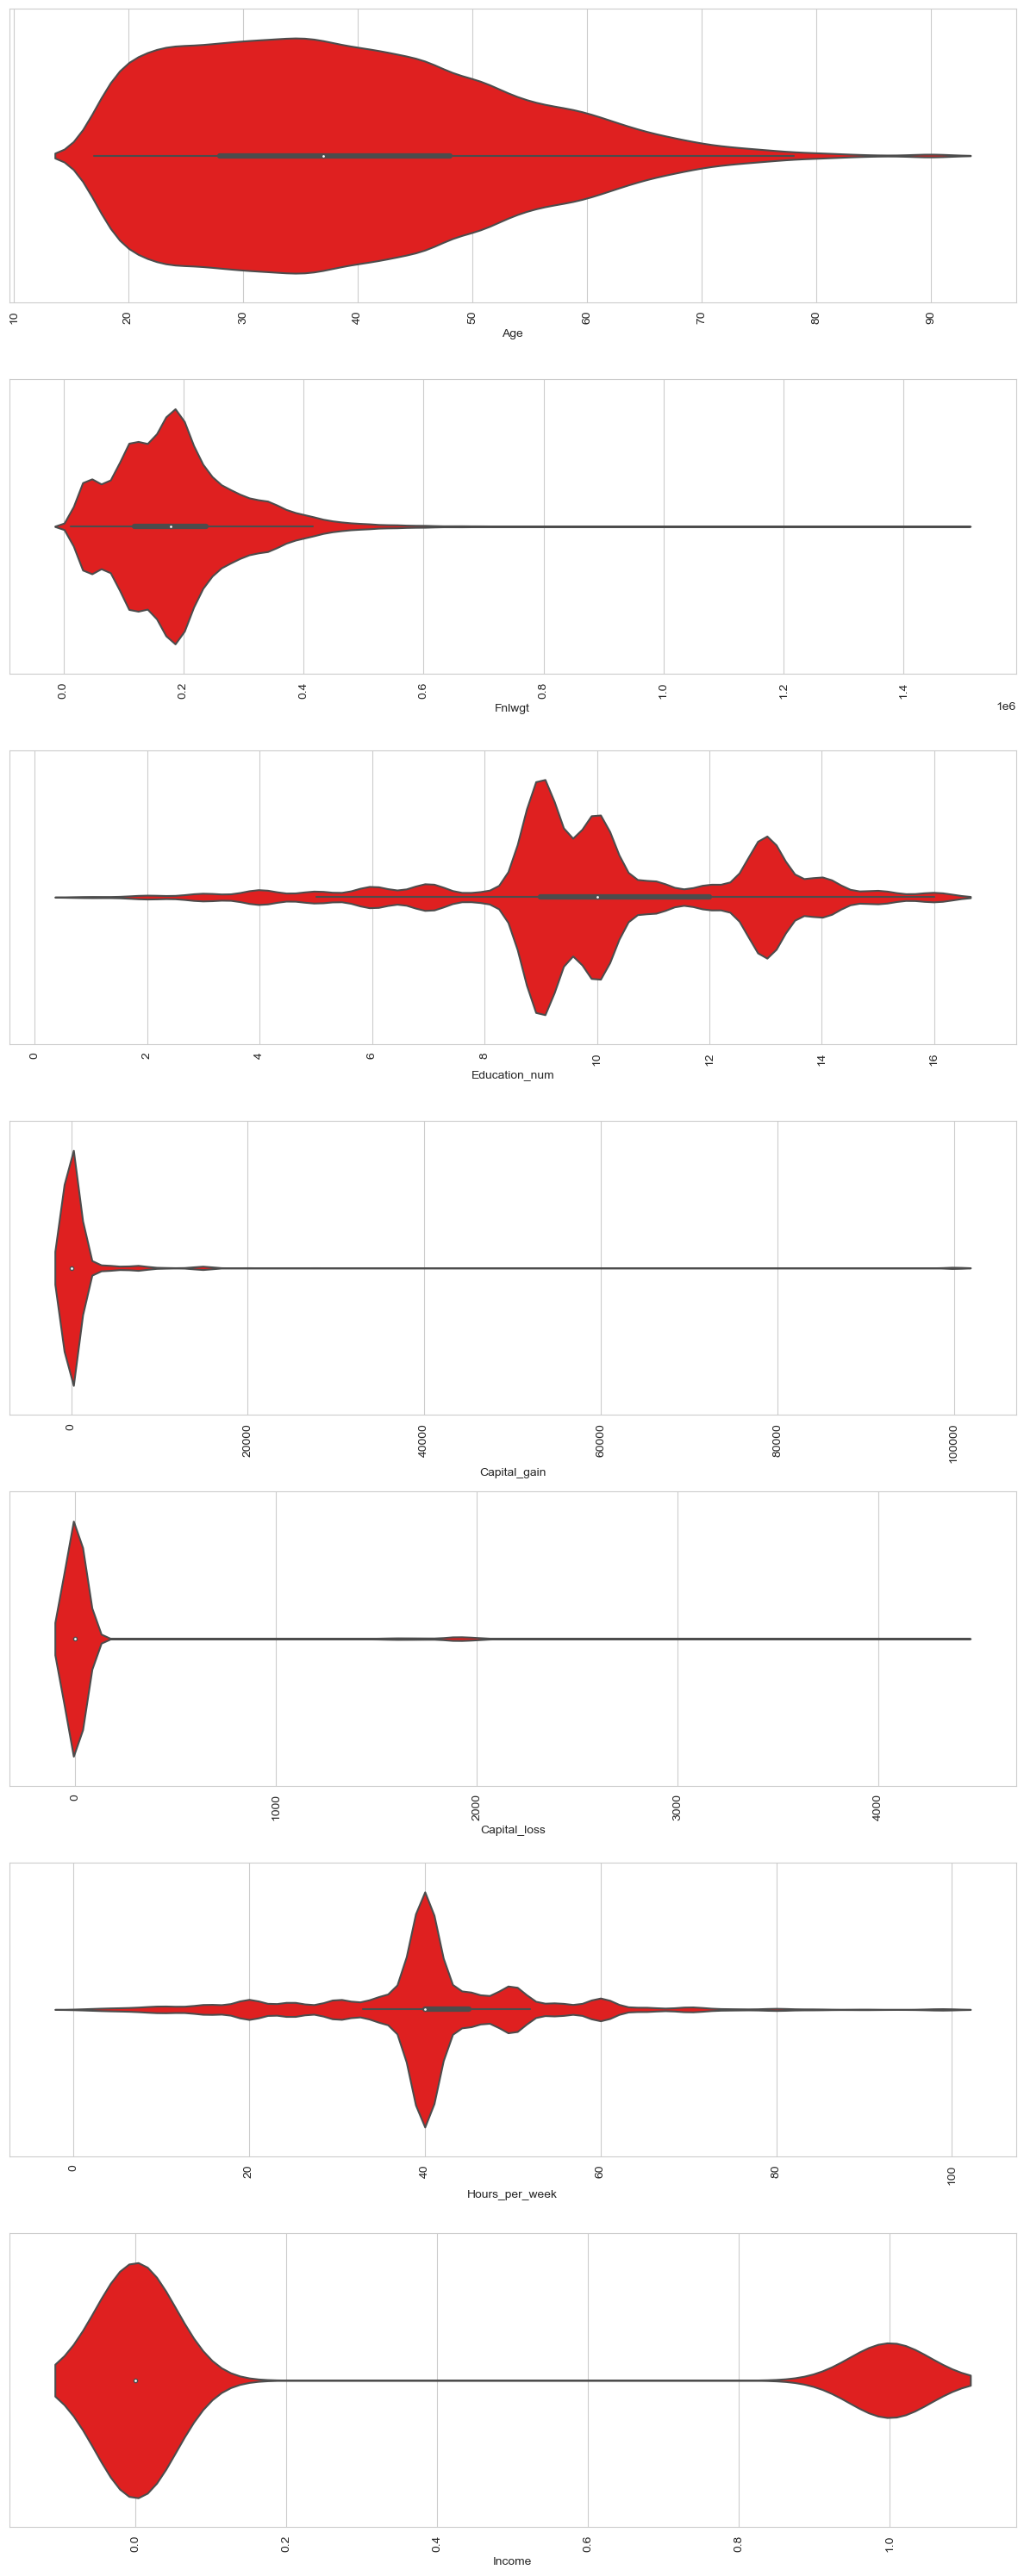

In [24]:
# Create the subplots
fig = plt.figure(figsize=(12, 30))

# Loop through categorical columns and plot count plots
for i, col in enumerate(num_col):
    plt.subplot(7, 1, i + 1)
    sns.violinplot(data=data, x=col,color="red")
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


## Bivariate analysis

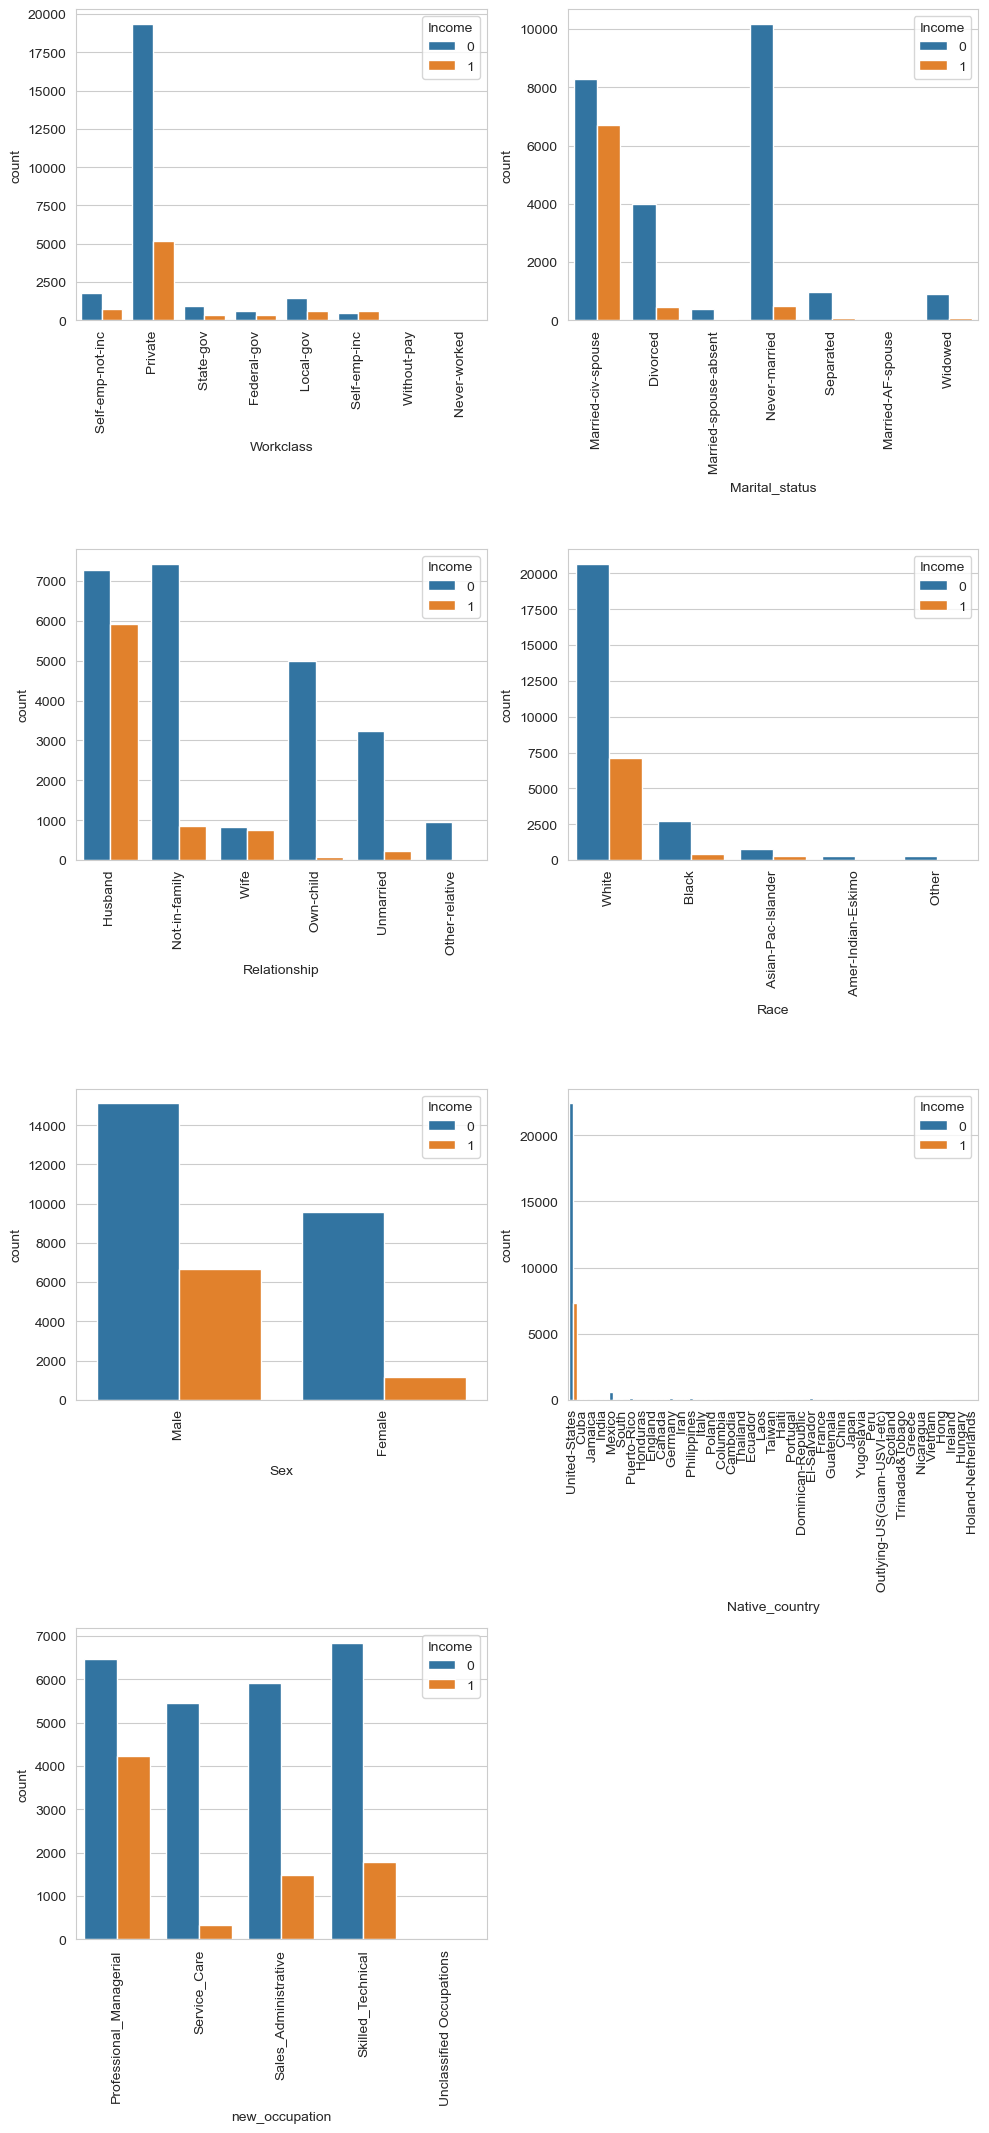

In [25]:
# Create the subplots 
fig = plt.figure(figsize=(10, 25)) # bivariate analysis categorical and income column

# Loop through categorical columns and plot count plots
for i, col in enumerate(cat_col):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=data, x=col,hue=data['Income'])
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### after looking into the visualizaiton we can say that private , marriedcivspouse,husband ,white ,Male, people of United states,professional_Managerial earn highest amoungest other over 50k

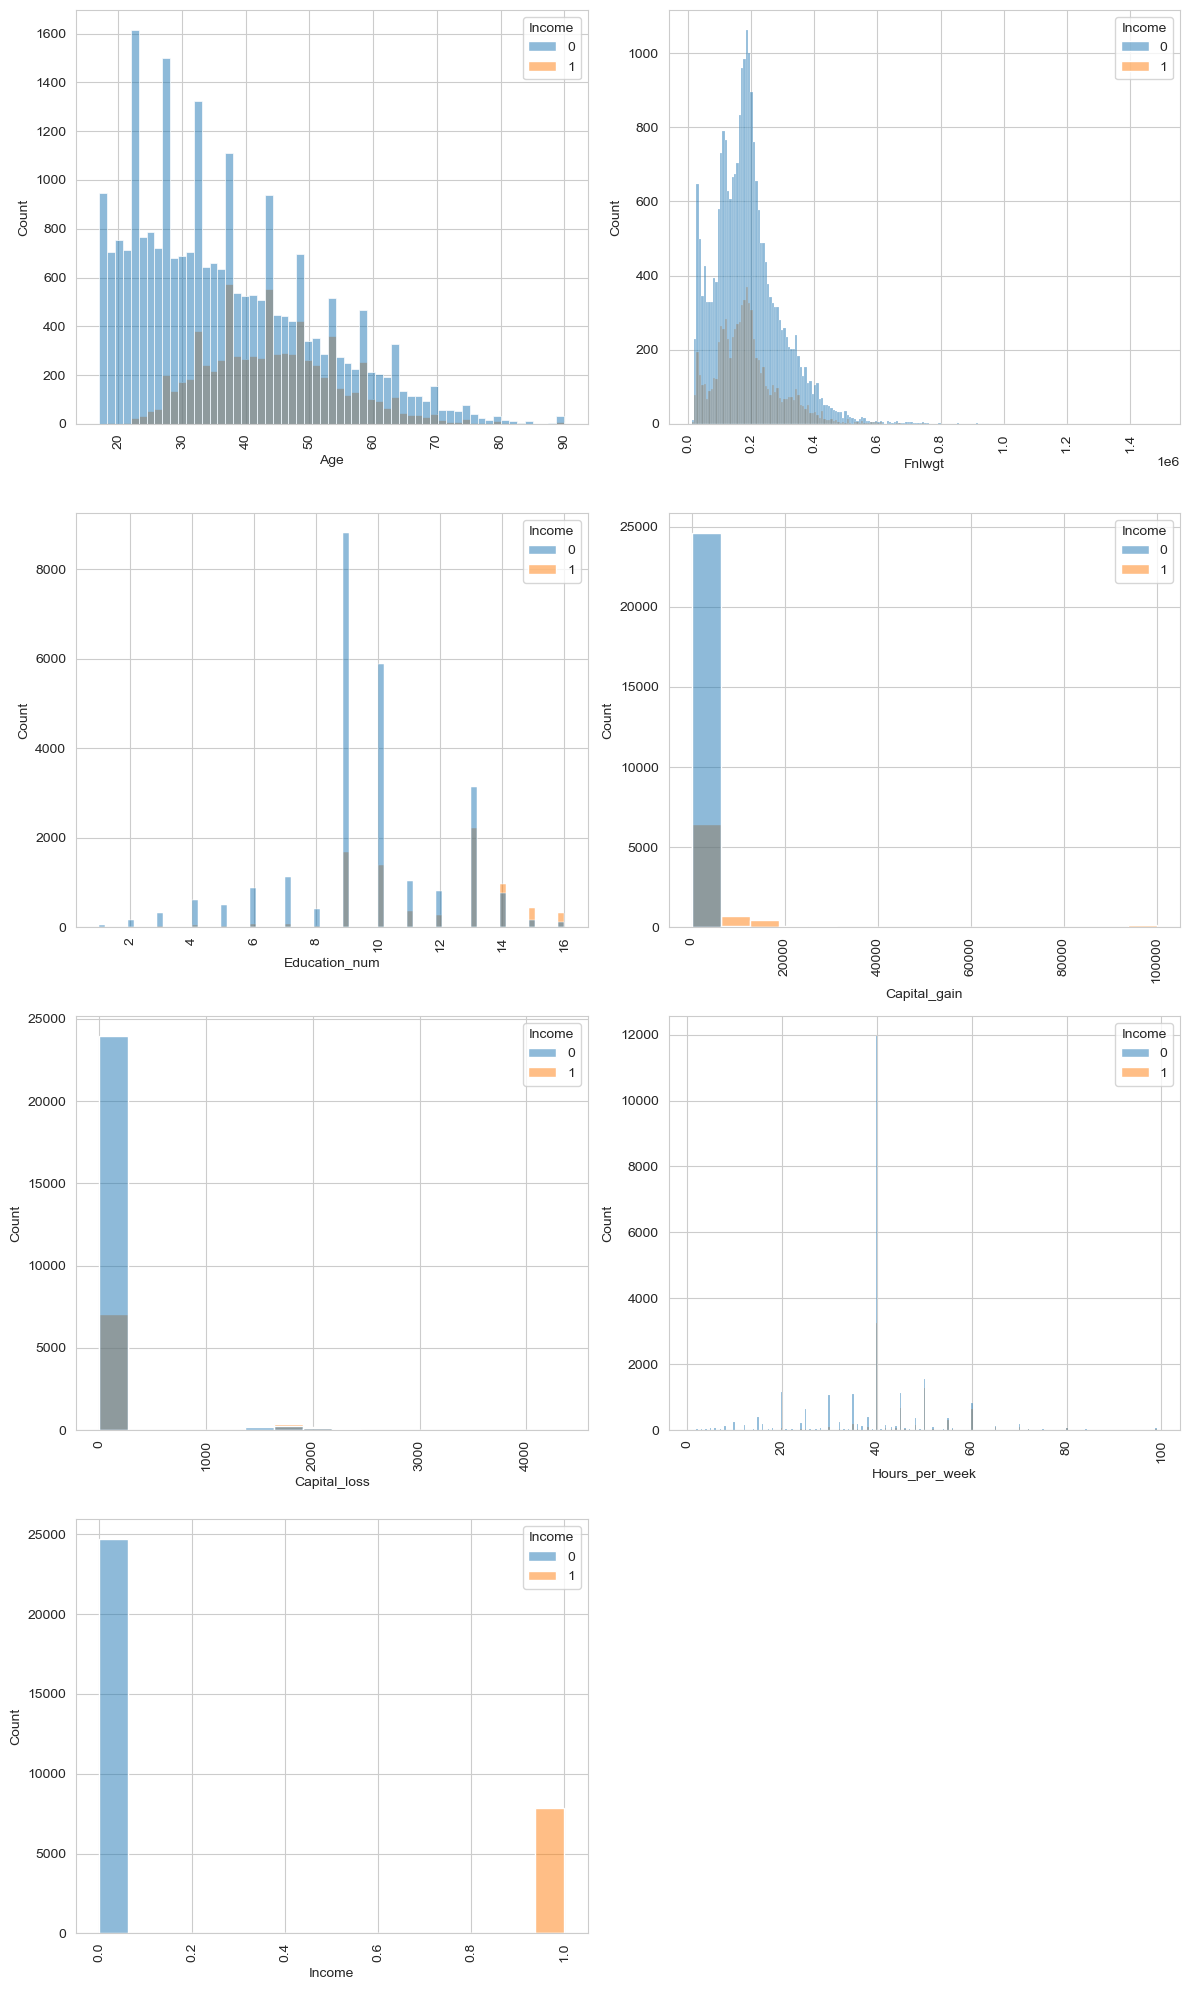

In [26]:
# Create the subplots
fig = plt.figure(figsize=(12, 20))


# Loop through numerical columns and plot count plots
for i, col in enumerate(num_col):
    plt.subplot(4, 2, i + 1)
    sns.histplot(data=data, x=col,hue=data['Income'])
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [97]:
data[['Hours_per_week','Income']].groupby(by = ['Hours_per_week']).agg('mean',).sort_values(by='Income' ,ascending=False)[:10]

,Income
Hours_per_week,
61,1.000000
67,0.750000
76,0.666667
97,0.500000
95,0.500000
89,0.500000
73,0.500000
55,0.466089
50,0.452964


* Age between 20 to 60 have highest chances to earn more than 50k
* Fnlwgt between 0 to 0.4 have highest chances to earn more than 50k
* The people with education num 14 have more chances to earn more than 50k
* The people with capital gain within 0.01 to 20000 have more chances to earn more than 50k
* people with capital loss between 0 to 100 have more chances to earn more than 50 k
* hours perweek 60 to 90 have more chance to earn more than 50k


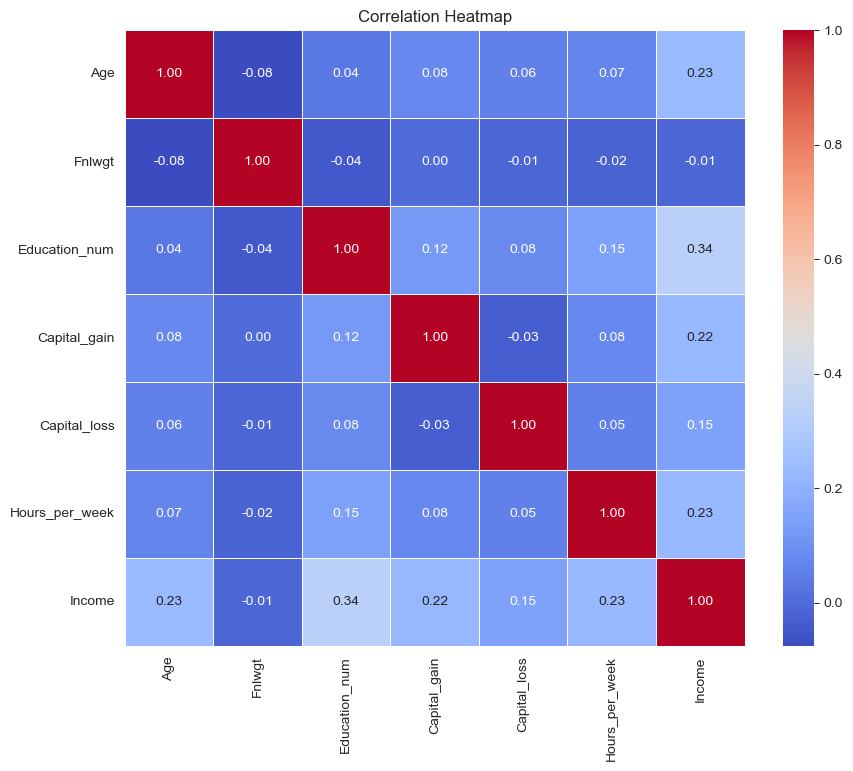

In [27]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### the correcation of the feature seems normal

<Figure size 1000x800 with 0 Axes>

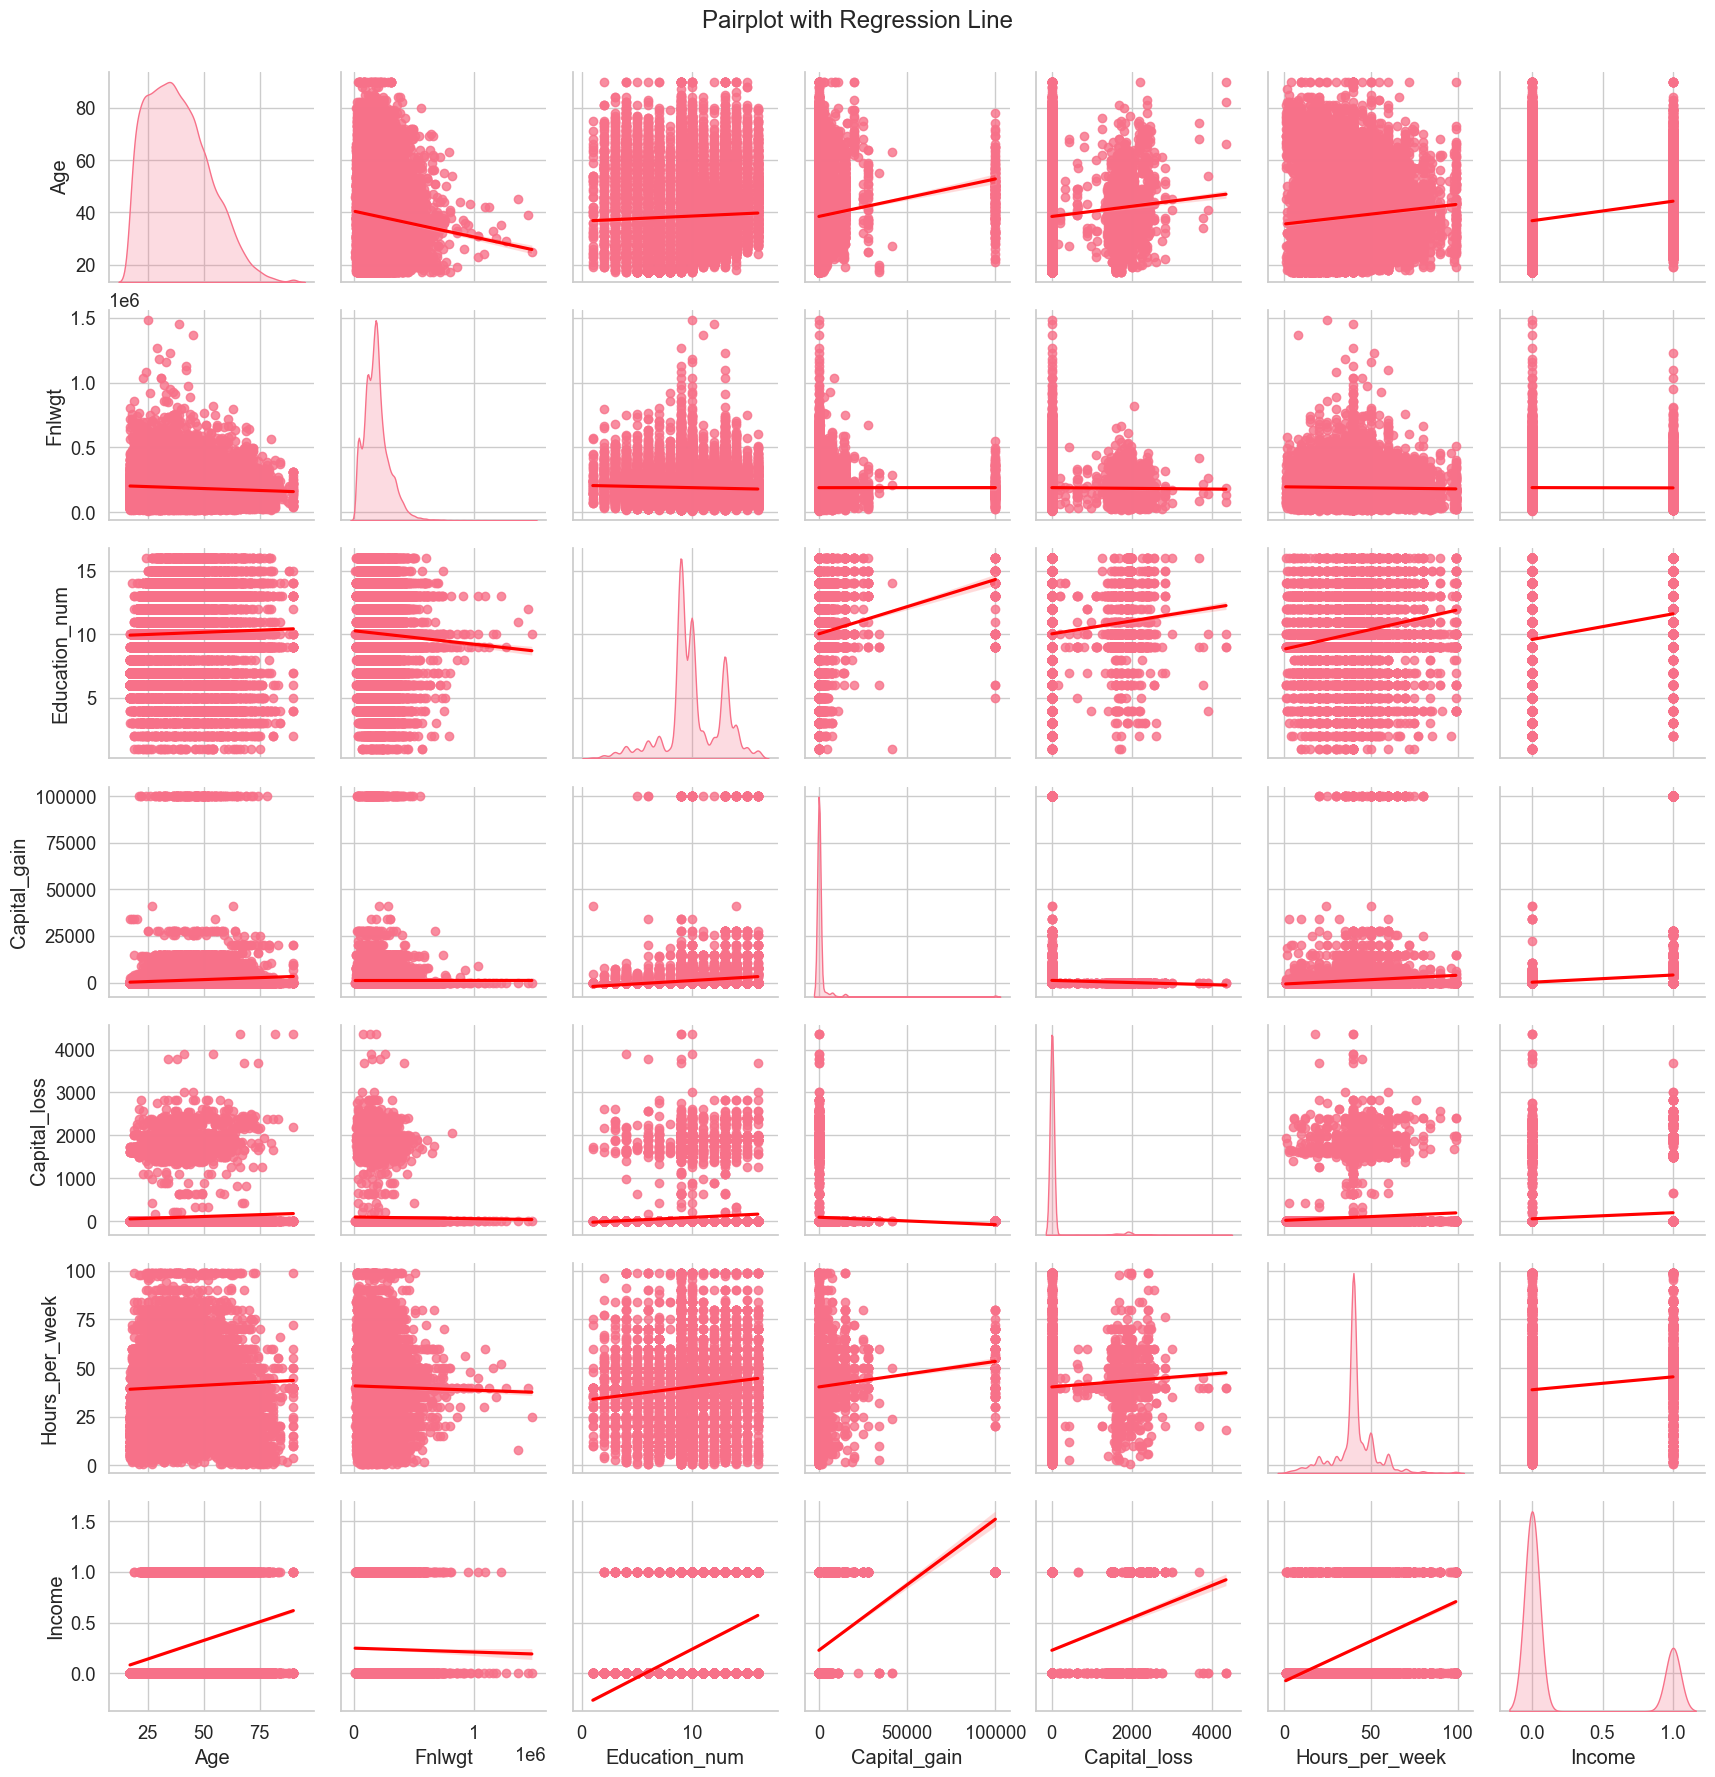

In [28]:
# Pairplot with regression line before handling outliers
# Customizing the Appearance
sns.set(style='whitegrid', font_scale=1.2)
sns.set_palette('husl')
plt.figure(figsize=(10, 8))

# Pairplot with regression line
sns.pairplot(data, kind='reg', diag_kind='kde', markers='o', plot_kws={'line_kws': {'color': 'red'}})

# Adding a title
plt.suptitle('Pairplot with Regression Line', y=1.02)

# Show the plot
plt.show()


## Encoding the categorical columns

In [31]:
# Using Label Encoder on categorical variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cat_col:
    data[i] = le.fit_transform(data[i])
data.head()



,Age,Workclass,Fnlwgt,Education_num,Marital_status,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income,new_occupation
0,50,5,83311,13,2,0,4,1,0,0,13,38,0,0
1,38,3,215646,9,0,1,4,1,0,0,40,38,0,2
2,53,3,234721,7,2,0,2,1,0,0,40,38,0,2
3,28,3,338409,13,2,5,2,0,0,0,40,4,0,0
4,37,3,284582,14,2,5,4,0,0,0,40,38,0,0


## Detecting the outliers

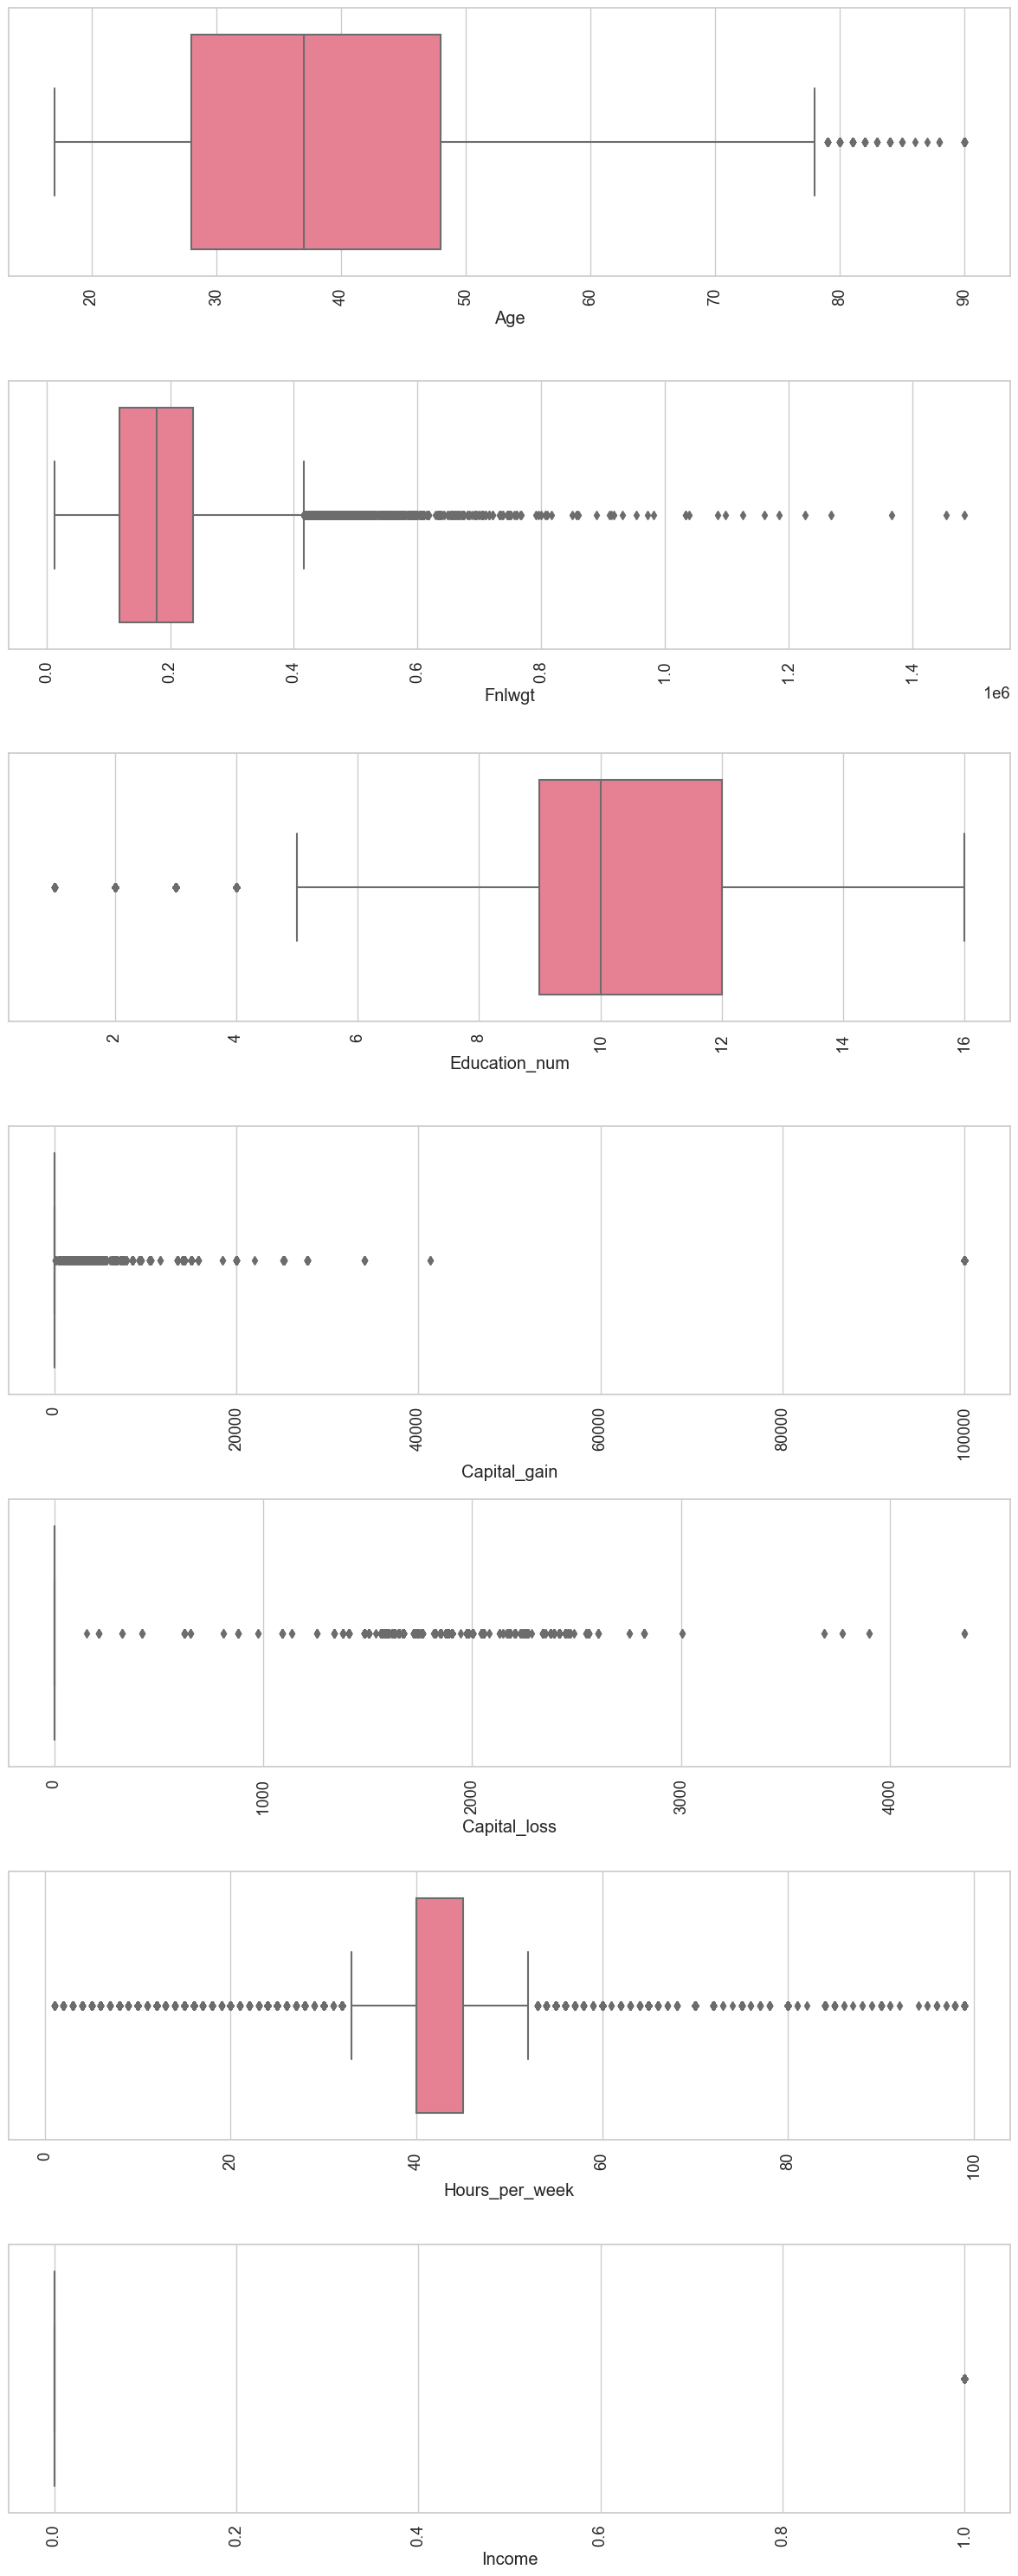

In [32]:
# Create the subplots
fig = plt.figure(figsize=(12, 30))


# Loop through numerical columns and plot count plots
for i, col in enumerate(num_col):
    plt.subplot(7,1 , i + 1)
    sns.boxplot(data=data, x=col,)
    plt.xlabel(col)
    plt.xticks(rotation=90)  # Rotate x-axis tick labels by 90 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()





In [34]:
from scipy.stats import zscore
z = np.abs(zscore(data))
threshold = 3
df2 = data[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", data.shape)
print ("Shape of the dataframe after removing outliers: ", df2.shape)
print ("Percentage of data loss post outlier removal: ", (data.shape[0]-df2.shape[0])/data.shape[0]*100)

Shape of the dataframe before removing outliers:  (32536, 14)
Shape of the dataframe after removing outliers:  (27751, 14)
Percentage of data loss post outlier removal:  14.706786328989427


In [47]:
df2.skew()

Age                0.484822
Workclass          0.081802
Fnlwgt             0.629037
Education_num     -0.145695
Marital_status    -0.045059
Relationship       0.753378
Race              -2.587054
Sex               -0.688876
Capital_gain       3.075536
Capital_loss      24.835174
Hours_per_week    -0.358726
Native_country    -5.411057
Income             1.322128
new_occupation     0.154960
dtype: float64

# skewness of the numeric features

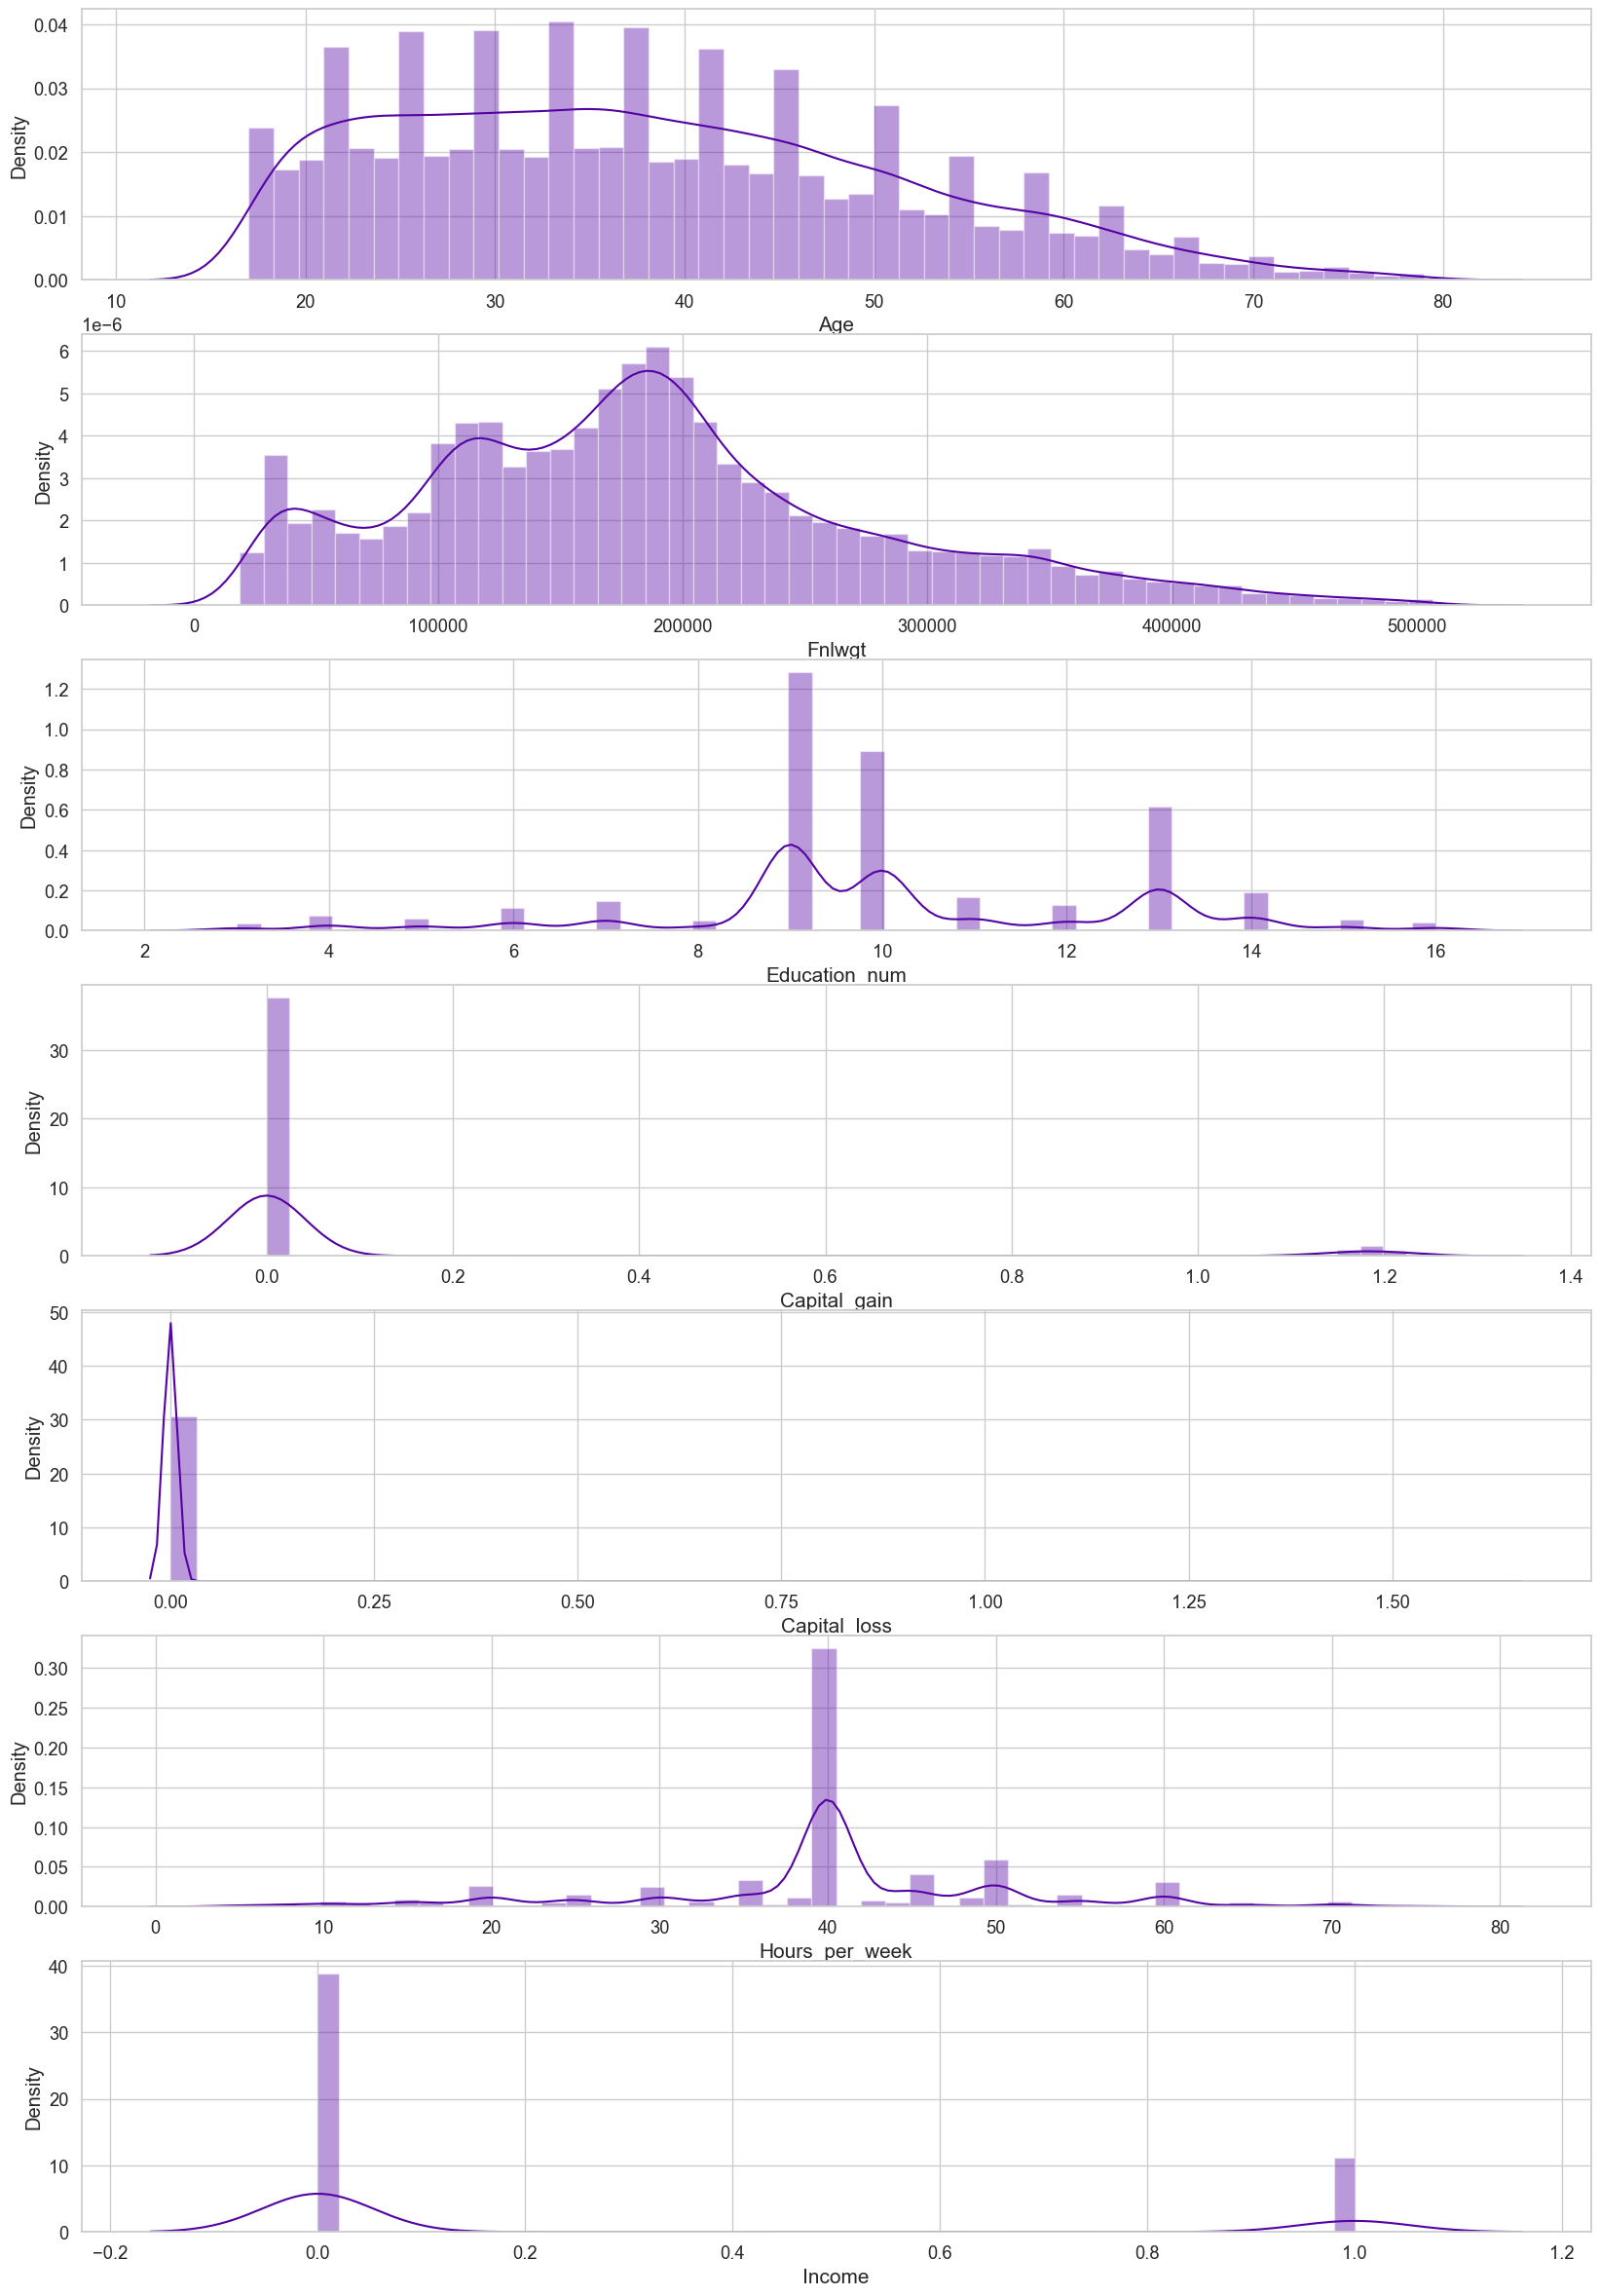

In [58]:
plt.figure(figsize=(20,60),facecolor='white')
sns.set_palette('plasma')
plotnum=1
for col in num_col:
    if plotnum<14:
        plt.subplot(14,1,plotnum)
        sns.distplot(df2[col])
        plt.xlabel(col,fontsize=15)
    plotnum+=1
plt.show()

### After looking into the data capital gain and capital loss have high skewness but due many values at zero now there are no outlier in the data . we will handle skewness  by using log transformation 

In [59]:
df2['Capital_gain'] = np.log1p(df2['Capital_gain'])
df2['Capital_loss'] = np.sqrt(df2['Capital_loss'])

In [60]:
df2.skew()

Age                0.484822
Workclass          0.081802
Fnlwgt             0.629037
Education_num     -0.145695
Marital_status    -0.045059
Relationship       0.753378
Race              -2.587054
Sex               -0.688876
Capital_gain       3.069278
Capital_loss      24.778187
Hours_per_week    -0.358726
Native_country    -5.411057
Income             1.322128
new_occupation     0.154960
dtype: float64

 ### checking correlation with target column

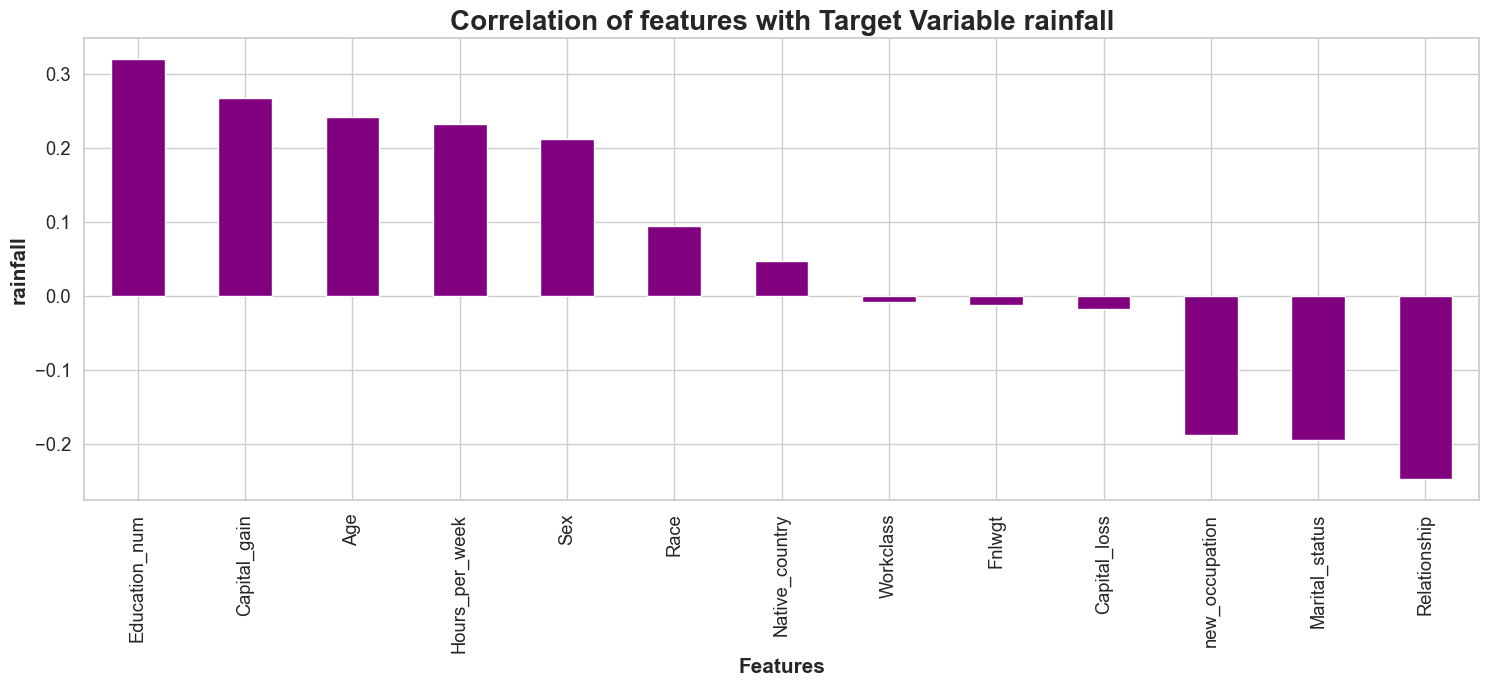

In [61]:
plt.figure(figsize = (18,6))
df2.corr()['Income'].drop(['Income']).sort_values(ascending=False).plot(kind='bar', color='purple')
plt.xlabel('Features', fontsize=15, fontweight='bold')
plt.ylabel('rainfall',fontsize= 15,fontweight='bold')
plt.title('Correlation of features with Target Variable rainfall',fontsize = 20,fontweight='bold')
plt.show()

* most of the features are positively correlated with target column and some have all most zero correlation with target and other have negative correlation with target .

##  balancing the targets using smote

<AxesSubplot:>

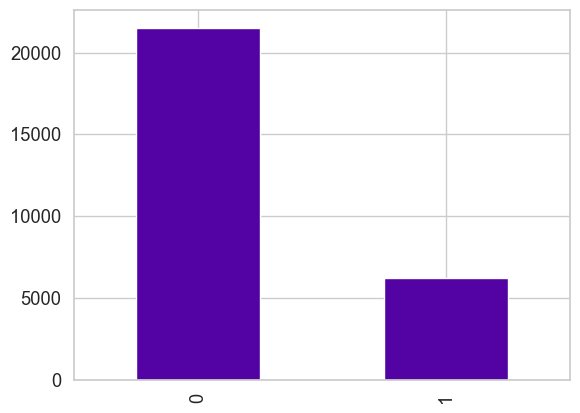

In [63]:
df2['Income'].value_counts().plot(kind ='bar')

In [65]:
# Splitting data in target and dependent feature
X = df2.drop("Income", axis =1 )
y = df2['Income']


In [69]:
# Oversampleing using SMOTE Techniques
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

y.value_counts()


0    21527
1    21527
Name: Income, dtype: int64

### Scaling the data

In [70]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scale = scaler.fit_transform(X)

## Checking Multicollinearity between features using variance_inflation_factor

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF values"] = [variance_inflation_factor(X_scale,i) for i in range(len(X.columns))]
vif["Features"] = X.columns
vif

,VIF values,Features
0,1.201181,Age
1,1.012975,Workclass
2,1.029039,Fnlwgt
3,1.328576,Education_num
4,1.151355,Marital_status
5,1.765125,Relationship
6,1.045392,Race
7,1.592722,Sex
8,1.045973,Capital_gain
9,1.003093,Capital_loss


* There is no feature having problem of multicollinearity

## PCA for feature selection 

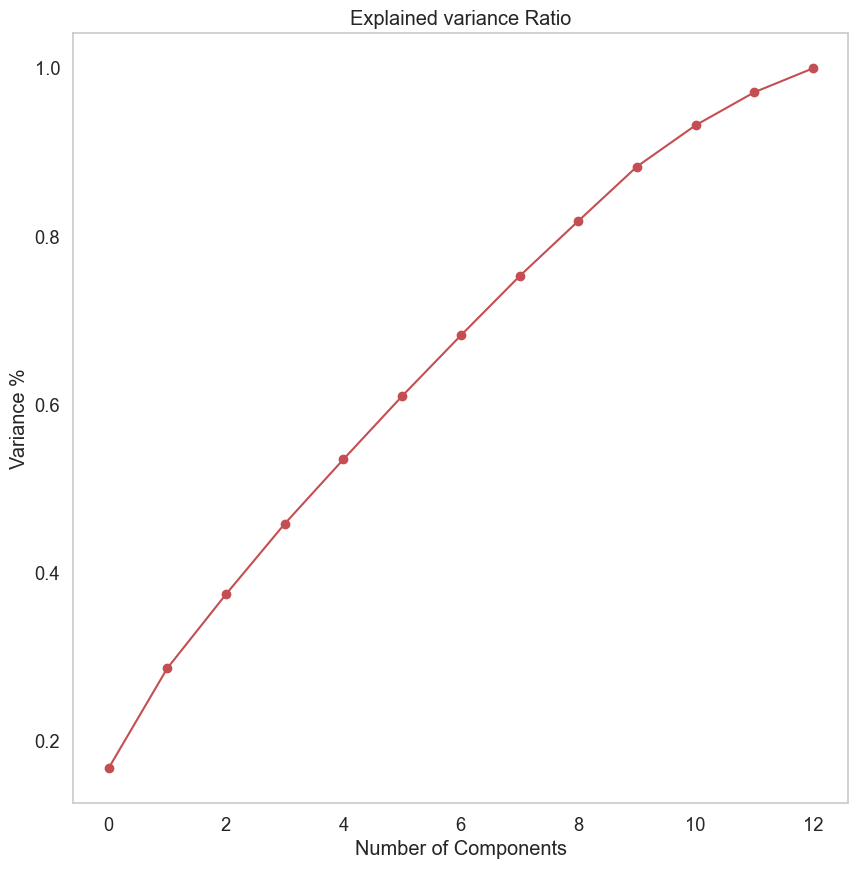

In [74]:
from sklearn.decomposition import PCA
pca = PCA()
#plot the graph to find the principal components
x_pca = pca.fit_transform(X_scale)
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Variance %')
plt.title('Explained variance Ratio')
plt.grid()

* Seem like every feature is important because curve is not getting flat at any point

## Train Test Split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, random_state=99, test_size=.3)

## Model building

## Logistic Regression

Logistic Regression with Hyperparameter Tuning:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      6391
           1       0.78      0.80      0.79      6526

    accuracy                           0.78     12917
   macro avg       0.78      0.78      0.78     12917
weighted avg       0.78      0.78      0.78     12917

Cross-Validation Scores: [0.73127395 0.77040994 0.79340379 0.78957148 0.80081301]
Mean Cross-Validation Score: 0.7770944330044857


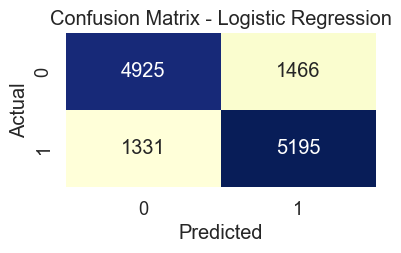

ROC AUC Score: 0.8629638493796319


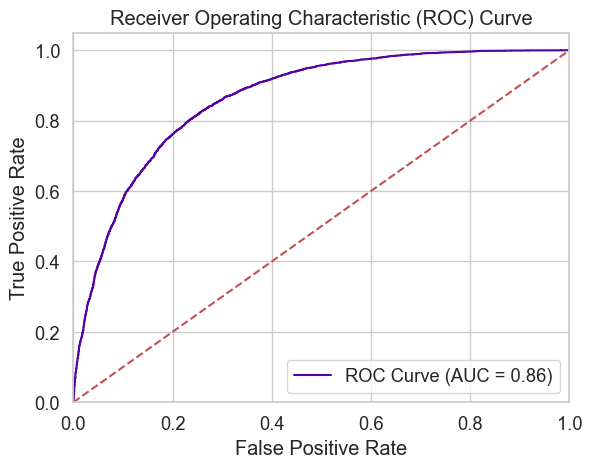

In [79]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create the Logistic Regression Classifier
LG = LogisticRegression()

# Create the grid search object
grid_search = GridSearchCV(LG, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the Logistic Regression Classifier with the best parameters
best_LG = LogisticRegression(**best_params)

# Fit the model on the training data
best_LG.fit(X_train, y_train)

# Make predictions on the test set
LG_y_pred = best_LG.predict(X_test)

print("Logistic Regression with Hyperparameter Tuning:")
# Classification Report
print("Classification Report:")
print(classification_report(y_test, LG_y_pred))

# Cross-Validation Score
scores = cross_val_score(best_LG, X_scale, y, cv=5)
print("Cross-Validation Scores:", scores)
mean_score = scores.mean()
print("Mean Cross-Validation Score:", mean_score)

# Plot confusion matrix as a heatmap
cm = confusion_matrix(y_test, LG_y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#ROC AUC Score
y_prob = best_LG.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

#  y_test contains true labels and y_prob contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## Decision Tree Classifier

Decision Tree Classifier with Hyperparameter Tuning:
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6391
           1       0.85      0.88      0.87      6526

    accuracy                           0.86     12917
   macro avg       0.86      0.86      0.86     12917
weighted avg       0.86      0.86      0.86     12917

Cross-Validation Scores: [0.75345488 0.84612705 0.88746952 0.88630821 0.89152149]
Mean Cross-Validation Score: 0.8529762285794135


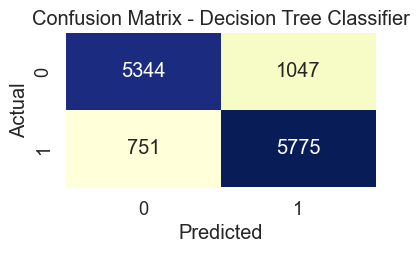

ROC AUC Score: 0.938886426778233


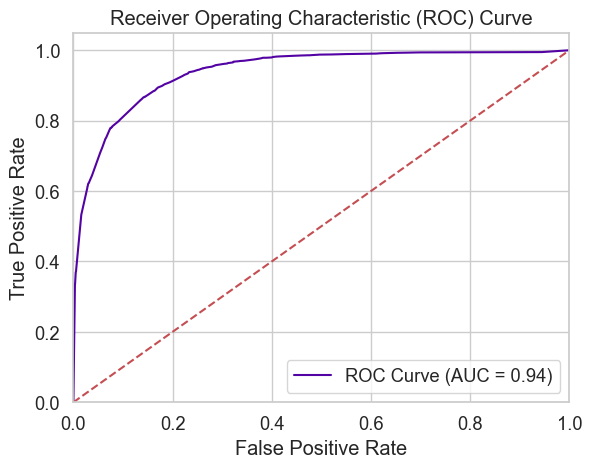

In [80]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the Decision Tree Classifier
dt = DecisionTreeClassifier()

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the Decision Tree Classifier with the best parameters
best_dt = DecisionTreeClassifier(**best_params)

# Fit the model on the training data
best_dt.fit(X_train, y_train)

# Make predictions on the test set
dt_y_pred = best_dt.predict(X_test)

print("Decision Tree Classifier with Hyperparameter Tuning:")
# Classification Report
print("Classification Report:")
print(classification_report(y_test, dt_y_pred))

# Cross-Validation Score
scores = cross_val_score(best_dt, X_scale, y, cv=5)
print("Cross-Validation Scores:", scores)
mean_score = scores.mean()
print("Mean Cross-Validation Score:", mean_score)

# Plot confusion matrix as a heatmap
cm = confusion_matrix(y_test, dt_y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#ROC AUC Score
y_prob = best_dt.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)


#ROC Curve
# Assuming y_test contains true labels and y_prob contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Random Forest Classifier

Random Forest Classifier with Hyperparameter Tuning:
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6391
           1       0.88      0.89      0.89      6526

    accuracy                           0.88     12917
   macro avg       0.88      0.88      0.88     12917
weighted avg       0.88      0.88      0.88     12917

Cross-Validation Scores: [0.7611195  0.86145628 0.90953432 0.91510858 0.91463415]
Mean Cross-Validation Score: 0.8723705640261606


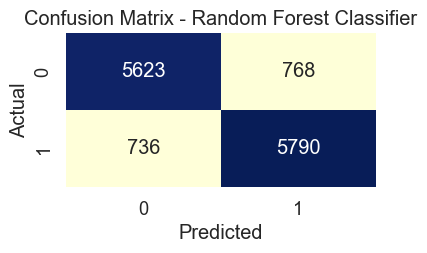

ROC AUC Score: 0.9552049376246563


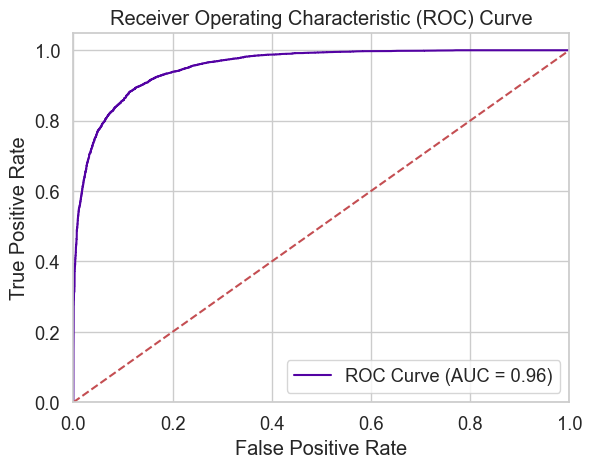

In [81]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest Classifier
RF = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(RF, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the Random Forest Classifier with the best parameters
best_RF = RandomForestClassifier(**best_params)

# Fit the model on the training data
best_RF.fit(X_train, y_train)

# Make predictions on the test set
RF_y_pred = best_RF.predict(X_test)

print("Random Forest Classifier with Hyperparameter Tuning:")
# Classification Report
print("Classification Report:")
print(classification_report(y_test, RF_y_pred))

# Cross-Validation Score
scores = cross_val_score(best_RF, X_scale, y, cv=5)
print("Cross-Validation Scores:", scores)
mean_score = scores.mean()
print("Mean Cross-Validation Score:", mean_score)

# Plot confusion matrix as a heatmap
cm = confusion_matrix(y_test, RF_y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC AUC Score
y_prob = best_RF.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

#ROC Curve
# Assuming y_test contains true labels and y_prob contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## K Neighbors Classifier

K Neighbors Classifier with Hyperparameter Tuning:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6391
           1       0.86      0.88      0.87      6526

    accuracy                           0.86     12917
   macro avg       0.86      0.86      0.86     12917
weighted avg       0.86      0.86      0.86     12917

Cross-Validation Scores: [0.7721519  0.84531413 0.88479851 0.88921147 0.8912892 ]
Mean Cross-Validation Score: 0.8565530435303357


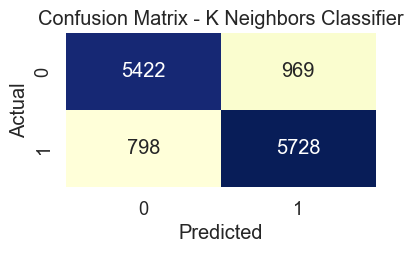

ROC AUC Score: 0.932204897296339


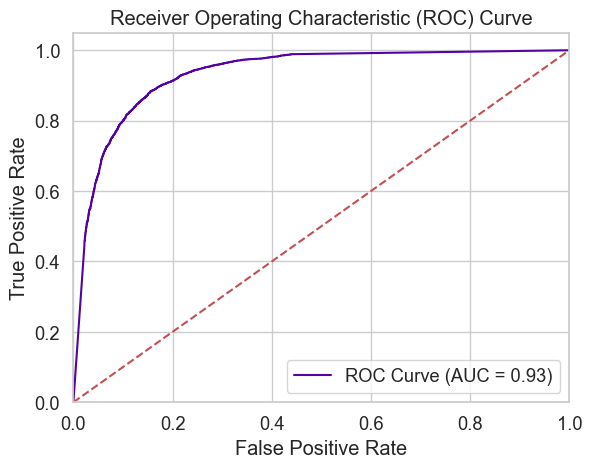

In [82]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the K Neighbors Classifier
KN = KNeighborsClassifier()

# Create the grid search object
grid_search = GridSearchCV(KN, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create the K Neighbors Classifier with the best parameters
best_KN = KNeighborsClassifier(**best_params)

# Fit the model on the training data
best_KN.fit(X_train, y_train)

# Make predictions on the test set
KN_y_pred = best_KN.predict(X_test)

print("K Neighbors Classifier with Hyperparameter Tuning:")
# Classification Report
print("Classification Report:")
print(classification_report(y_test, KN_y_pred))

# Cross-Validation Score
scores = cross_val_score(best_KN, X_scale, y, cv=5)
print("Cross-Validation Scores:", scores)
mean_score = scores.mean()
print("Mean Cross-Validation Score:", mean_score)

# Plot confusion matrix as a heatmap
cm = confusion_matrix(y_test, KN_y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix - K Neighbors Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC AUC Score
y_prob = best_KN.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

#ROC Curve
# Assuming y_test contains true labels and y_prob contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Creating dataset Of all Models

In [87]:
# Create a list of model names
model_names = [ 'Random Forest Classifier', 'Decision Tree Classifier', 'Logistic Regression',"K Neighbors Classifier"]

# Create a list of models and their corresponding accuracy scores
models = [ RF, dt, LG,KN ,SV,XGB]
accuracy_scores = [ accuracy_score(y_test, RF_y_pred), accuracy_score(y_test, dt_y_pred), accuracy_score(y_test, LG_y_pred),accuracy_score(y_test, KN_y_pred)]

# Create a dataframe with model name and accuracy score
df = pd.DataFrame({'Model Name': model_names, 'Accuracy Score': accuracy_scores})

# Sort the dataframe by accuracy score in descending order
df = df.sort_values('Accuracy Score', ascending=False)

# Print the dataframe
df.index = range(1, len(df)+1)
print(df)

                 Model Name  Accuracy Score
1  Random Forest Classifier        0.883564
2    K Neighbors Classifier        0.863204
3  Decision Tree Classifier        0.860804
4       Logistic Regression        0.783464


## Saving the model

In [88]:
import pickle
with open('best_model','wb') as f:
    pickle.dump(best_RF,f)
pickle.dump(X_scale, open('scaler.pkl','wb'))